In [20]:
%load_ext autoreload
%autoreload 2
%matplotlib ipympl

import dotenv
import torch
import matplotlib.pyplot as plt
import mlflow
import os
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.model_selection import KFold
from intra import IntrA
from models.pointnet import PointNetCls
from models.pointnet2 import PointNet2
from models.pointconv import PointConvDensityClsSsg
from utils import train_model, eval_model

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

dotenv.load_dotenv()  # load the MLflow http authentication parameters
mlflow.set_tracking_uri(os.environ.get("MLFLOW_TRACKING_URI"))

dev = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

print(dev)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
mps


In [1]:
dataset = IntrA("/data/", dataset="generated", npoints=1024, exclude_seg=True)

tacc = 0
kf = KFold(n_splits=5, shuffle=True, random_state=0)
for fold, (train_ids, test_ids) in enumerate(kf.split(dataset), start=1):
    model = PointNetCls(k=2, feature_transform=False)
    # if opt.model != "":
    #     model.load_state_dict(torch.load(opt.model))

    train_srs, test_srs = SubsetRandomSampler(train_ids), SubsetRandomSampler(test_ids)
    train_dl = DataLoader(dataset, batch_size=8, sampler=train_srs)
    test_dl = DataLoader(dataset, batch_size=8, sampler=test_srs)
    train_model(model, train_dl, test_dl, model_name=f"PointNet_Fold{fold}")
    facc = eval_model(model, test_dl)
    tacc += facc
    print(f"Fold: {fold}. Fold acc: {facc}. Overall acc: {tacc/fold}.")

NameError: name 'IntrA' is not defined

In [24]:
dataset = IntrA("./data", dataset="generated", npoints=1024, exclude_seg=True, norm=True)
trn, tst = torch.utils.data.random_split(dataset, [0.8, 0.2], torch.Generator().manual_seed(42))

# model = PointNetCls(k=2, feature_transform=False)
# model = PointNet2(2, normal_channel=False)
model = PointConvDensityClsSsg(2)

train_dl = DataLoader(trn, batch_size=8, num_workers=16)
test_dl = DataLoader(tst, batch_size=8, num_workers=16)
train_model(model, train_dl, test_dl, epochs=100, checkpoint_epoch=10, model_name="PointConv", norm=True)

/Users/jventers/miniconda3/envs/masters-env/lib/python3.9/site-packages/torch/optim/lr_scheduler.py:139: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


KeyboardInterrupt: 

In [7]:
loaded_model = PointNetCls(k=2, feature_transform=False)
loaded_model.to(dev)
snapshot = torch.load("./snapshots/PointNet_6.ckpt", map_location=torch.device(dev))
loaded_model.load_state_dict(snapshot['state_dict'])
acc = eval_model(loaded_model, test_dl, verbose=True)
print(acc)

100%|██████████| 48/48 [00:01<00:00, 24.55it/s]

{0: 321, 1: 10}
Class Accuracies:
vessel: 321/345=0.9304347826086956
aneurysm: 10/36=0.2777777777777778
(0.868766404199475, {0: 321, 1: 10}, {0: 345, 1: 36})


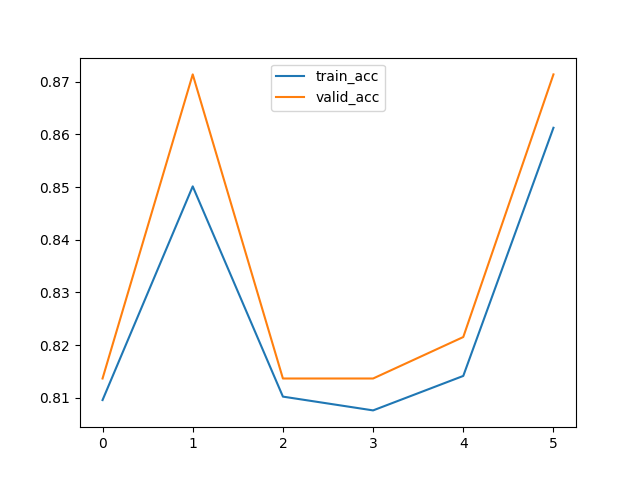

In [8]:
fig, ax = plt.subplots()
ax.plot(snapshot["history"]["train_acc"], label="train_acc")
ax.plot(snapshot["history"]["valid_acc"], label="valid_acc")
ax.legend()
plt.show()